In [5]:
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from lane_lines.calibration import load_calibration
from lane_lines.Image_Processor import Image_Processor
from lane_lines.Line import Line

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

cam_matrix, dist_coeff = load_calibration('camera_cal')

src = np.float32([[238, 688] , [1071, 688] ,[595, 449],[687, 449]])
dst = np.float32([[280, 720] , [1000, 720] ,[280, 0],[1000, 0]])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
image_processor = Image_Processor(cam_matrix, dist_coeff, M, M_inv)
# out = image_processor.process_image(mpimg.imread('test_images/test1.jpg'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
video_output = 'output_videos/project_video2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")#.subclip(39,45)
white_clip = clip1.fl_image(image_processor.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video2.mp4.
Moviepy - Writing video output_videos/project_video2.mp4




t:   2%|▏         | 29/1260 [00:10<07:46,  2.64it/s, now=None]

KeyboardInterrupt: 

## Undistort Image

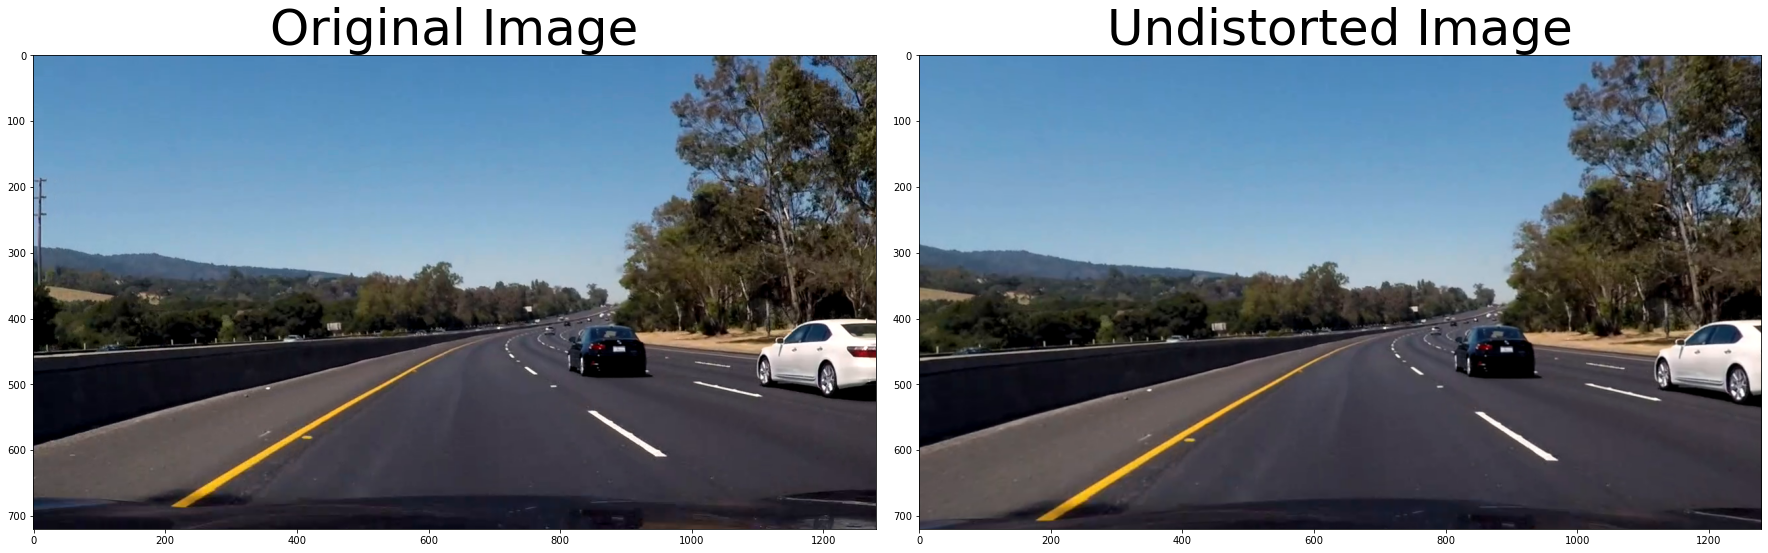

In [3]:
image_processor.undistort()

img_undist = image_processor.img_undist#cv2.undistort(img_orig, cam_matrix, dist_coeff, None, cam_matrix)    
                   
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_processor.img_orig)#,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undist, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Thresholding

In [11]:
np.sign(image_processor.line_right.best_fit[0])

-1.0

In [10]:
image_processor.line_left.best_fit

array([ 1.18820318e-03, -1.38885461e+00,  7.04709839e+02])

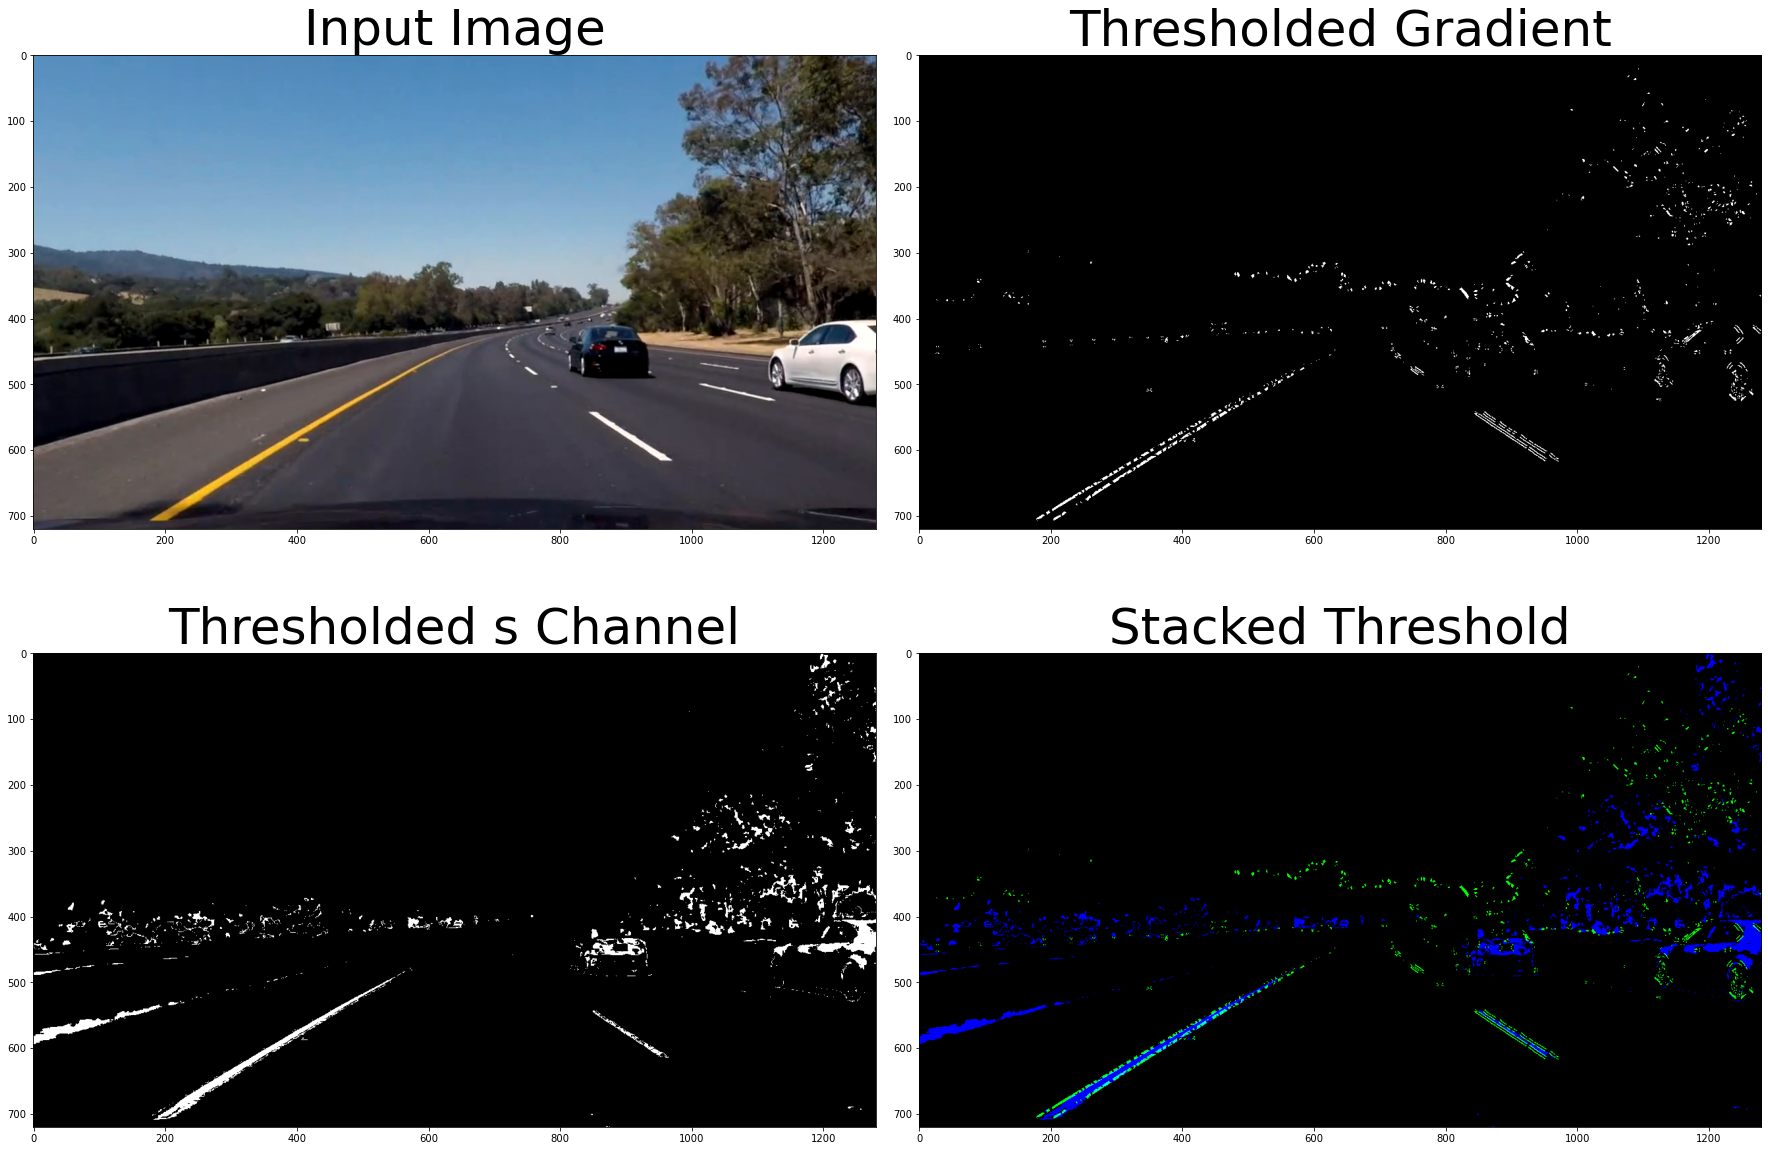

In [4]:
# image_processor.calc_abs_gradient_binary(kernel_sizes=(3,7,11), thresh=(60, 150))
# image_processor.calc_dir_gradient_binary(kernel_sizes=(3,7,11), thresh=(30, 60), degrees=True)
# image_processor.calc_hls_thresh_binary(channel='s', thresh=(160, 255))
# image_processor.calc_combined_binary()
# Plot the result
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 18))
f.tight_layout()
ax1.imshow(image_processor.img_undist)
ax1.set_title('Input Image', fontsize=50)
ax2.imshow(image_processor.abs_gradient_binary * image_processor.dir_gradient_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
ax3.imshow(image_processor.hls_thresh_binary, cmap='gray')
ax3.set_title('Thresholded s Channel', fontsize=50)
ax4.imshow(image_processor.color_binary())#, cmap='gray')
ax4.set_title('Stacked Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspektive Transform

Text(0.5, 1.0, 'Warped Binary Image')

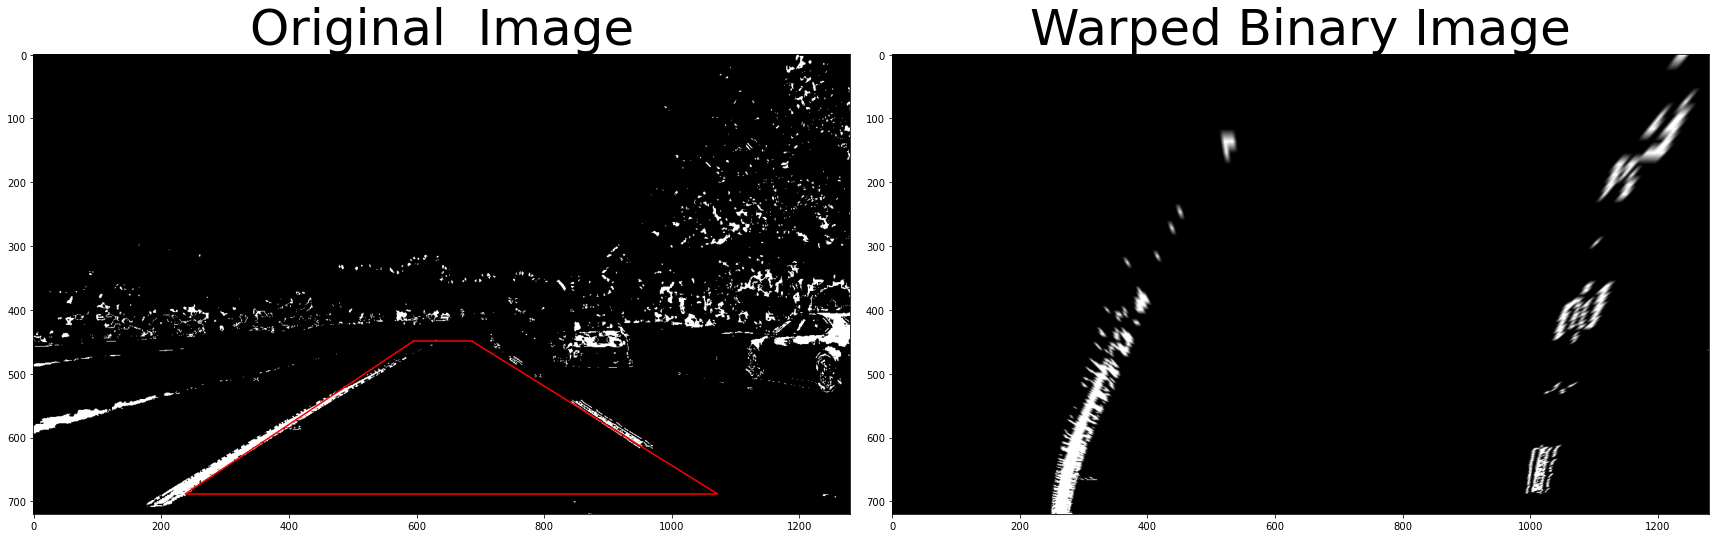

In [5]:
# image_processor.warp_perspective_binary()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_processor.combined_binary, cmap='gray')
ax1.set_title('Original  Image', fontsize=50)
ax1.plot([src[0][0], src[1][0]], [src[0][1], src[1][1]], color='red')
ax1.plot([src[1][0], src[3][0]], [src[1][1], src[3][1]], color='red')
ax1.plot([src[3][0], src[2][0]], [src[3][1], src[2][1]], color='red')
ax1.plot([src[0][0], src[2][0]], [src[0][1], src[2][1]], color='red')
ax2.imshow(image_processor.combined_binary_warped, cmap='gray')
ax2.set_title('Warped Binary Image', fontsize=50)
# ax2.axvline(280, color='red')
# ax2.axvline(310, color='red')
# ax2.axvline(970, color='red')
# ax2.axvline(1000, color='red')

In [6]:
img_sliding_window = image_processor.find_lane_pixels_sliding_window(return_image=True)
img_poly = image_processor.find_lane_pixels_poly(return_image=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_sliding_window, cmap='gray')
ax1.set_title('Sliding Window', fontsize=50)
ax2.imshow(img_poly, cmap='gray')
ax2.set_title('Look Ahead', fontsize=50)
# ax2.axvline(280, color='red')
# ax2.axvline(310, color='red')
# ax2.axvline(970, color='red')
# ax2.axvline(1000, color='red')

print(image_processor.line_left.measure_curvature_real())
print(image_processor.line_right.measure_curvature_real())

TypeError: expected non-empty vector for x

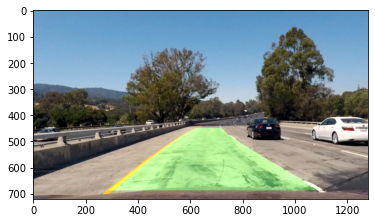

In [49]:
plt.imshow(image_processor.draw_lane())

t:   0%|          | 0/175 [00:00<?, ?it/s, now=None]

fails: 1000 1000
Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4

fails: 0 0


TypeError: expected non-empty vector for x

In [20]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(video_output))